In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [4]:
def make_dataset(onto, fact, n_queries=32_000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.121
demacare - balance 0.0424
stuff - balance 0.2303
swo - balance 0.287
ontodt - balance 0.0893
pizza - balance 0.4105


In [5]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240709T102958/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data, None, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params, train_identities=True, identities_weight=0.13)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 6001/6000 | loss 1.6238 | val loss 1.4164 | acc 0.7066 | f1 0.3768 | prec 0.3237 | recall 0.4508 | roc auc 0.6630 | pr auc 0.3424 | elapsed 139.77s
train epoch 01/10 | batch 6001/6000 | loss 0.8545 | val loss 0.3134 | acc 0.8867 | f1 0.7161 | prec 0.7061 | recall 0.7263 | roc auc 0.9203 | pr auc 0.7863 | elapsed 462.53s
train epoch 02/10 | batch 6001/6000 | loss 0.4314 | val loss 0.2214 | acc 0.9176 | f1 0.7947 | prec 0.7796 | recall 0.8104 | roc auc 0.9537 | pr auc 0.8694 | elapsed 1921.73s
train epoch 03/10 | batch 6001/6000 | loss 0.3507 | val loss 0.1883 | acc 0.9300 | f1 0.8253 | prec 0.8106 | recall 0.8405 | roc auc 0.9655 | pr auc 0.8990 | elapsed 294.95s
train epoch 04/10 | batch 6001/6000 | loss 0.3091 | val loss 0.1672 | acc 0.9386 | f1 0.8459 | prec 0.8361 | recall 0.8560 | roc auc 0.9721 | pr auc 0.9163 | elapsed 357.84s
train epoch 05/10 | batch 6001/6000 | loss 0.2799 | val loss 0.1520 | acc 0.9450 | f1 0.8621

In [6]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


print('frozen reasoner head (transfer) original')
T.manual_seed(seed)
transfer_log_orig = train(data, None, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer) original
train epoch 00/10 | batch 6001/6000 | loss 1.1305 | val loss 1.1305 | acc 0.6578 | f1 0.4654 | prec 0.3359 | recall 0.7571 | roc auc 0.7495 | pr auc 0.4917 | elapsed 76.08s
train epoch 01/10 | batch 6001/6000 | loss 0.4362 | val loss 0.2192 | acc 0.9211 | f1 0.8003 | prec 0.7967 | recall 0.8040 | roc auc 0.9480 | pr auc 0.8682 | elapsed 282.30s
train epoch 02/10 | batch 6001/6000 | loss 0.2012 | val loss 0.1719 | acc 0.9423 | f1 0.8508 | prec 0.8664 | recall 0.8358 | roc auc 0.9664 | pr auc 0.9099 | elapsed 271.70s
train epoch 03/10 | batch 6001/6000 | loss 0.1726 | val loss 0.1552 | acc 0.9481 | f1 0.8649 | prec 0.8868 | recall 0.8442 | roc auc 0.9726 | pr auc 0.9234 | elapsed 224.25s
train epoch 04/10 | batch 6001/6000 | loss 0.1593 | val loss 0.1461 | acc 0.9504 | f1 0.8709 | prec 0.8924 | recall 0.8504 | roc auc 0.9759 | pr auc 0.9303 | elapsed 234.62s
train epoch 05/10 | batch 6001/6000 | loss 0.1514 | val loss 0.1396 | acc 0.9533 | f1 0.87

local/out/exp/20240709T140400
------
Frozen pre-trained reasoner head original
train time 11470.625259399414
           mean     std   micro
acc      0.9595  0.0223  0.9595
prec     0.9115  0.0603  0.9124
recall   0.8423  0.1137  0.8786
f1       0.8738  0.0851  0.8952
auc_roc  0.9776  0.0156  0.9831
auc_pr   0.9280  0.0572  0.9490
------
Frozen pre-trained reasoner head
train time 5566.795304298401
           mean     std   micro
acc      0.9618  0.0177  0.9618
prec     0.8881  0.0437  0.8967
recall   0.8818  0.0897  0.9108
f1       0.8842  0.0655  0.9037
auc_roc  0.9841  0.0088  0.9879
auc_pr   0.9419  0.0455  0.9608


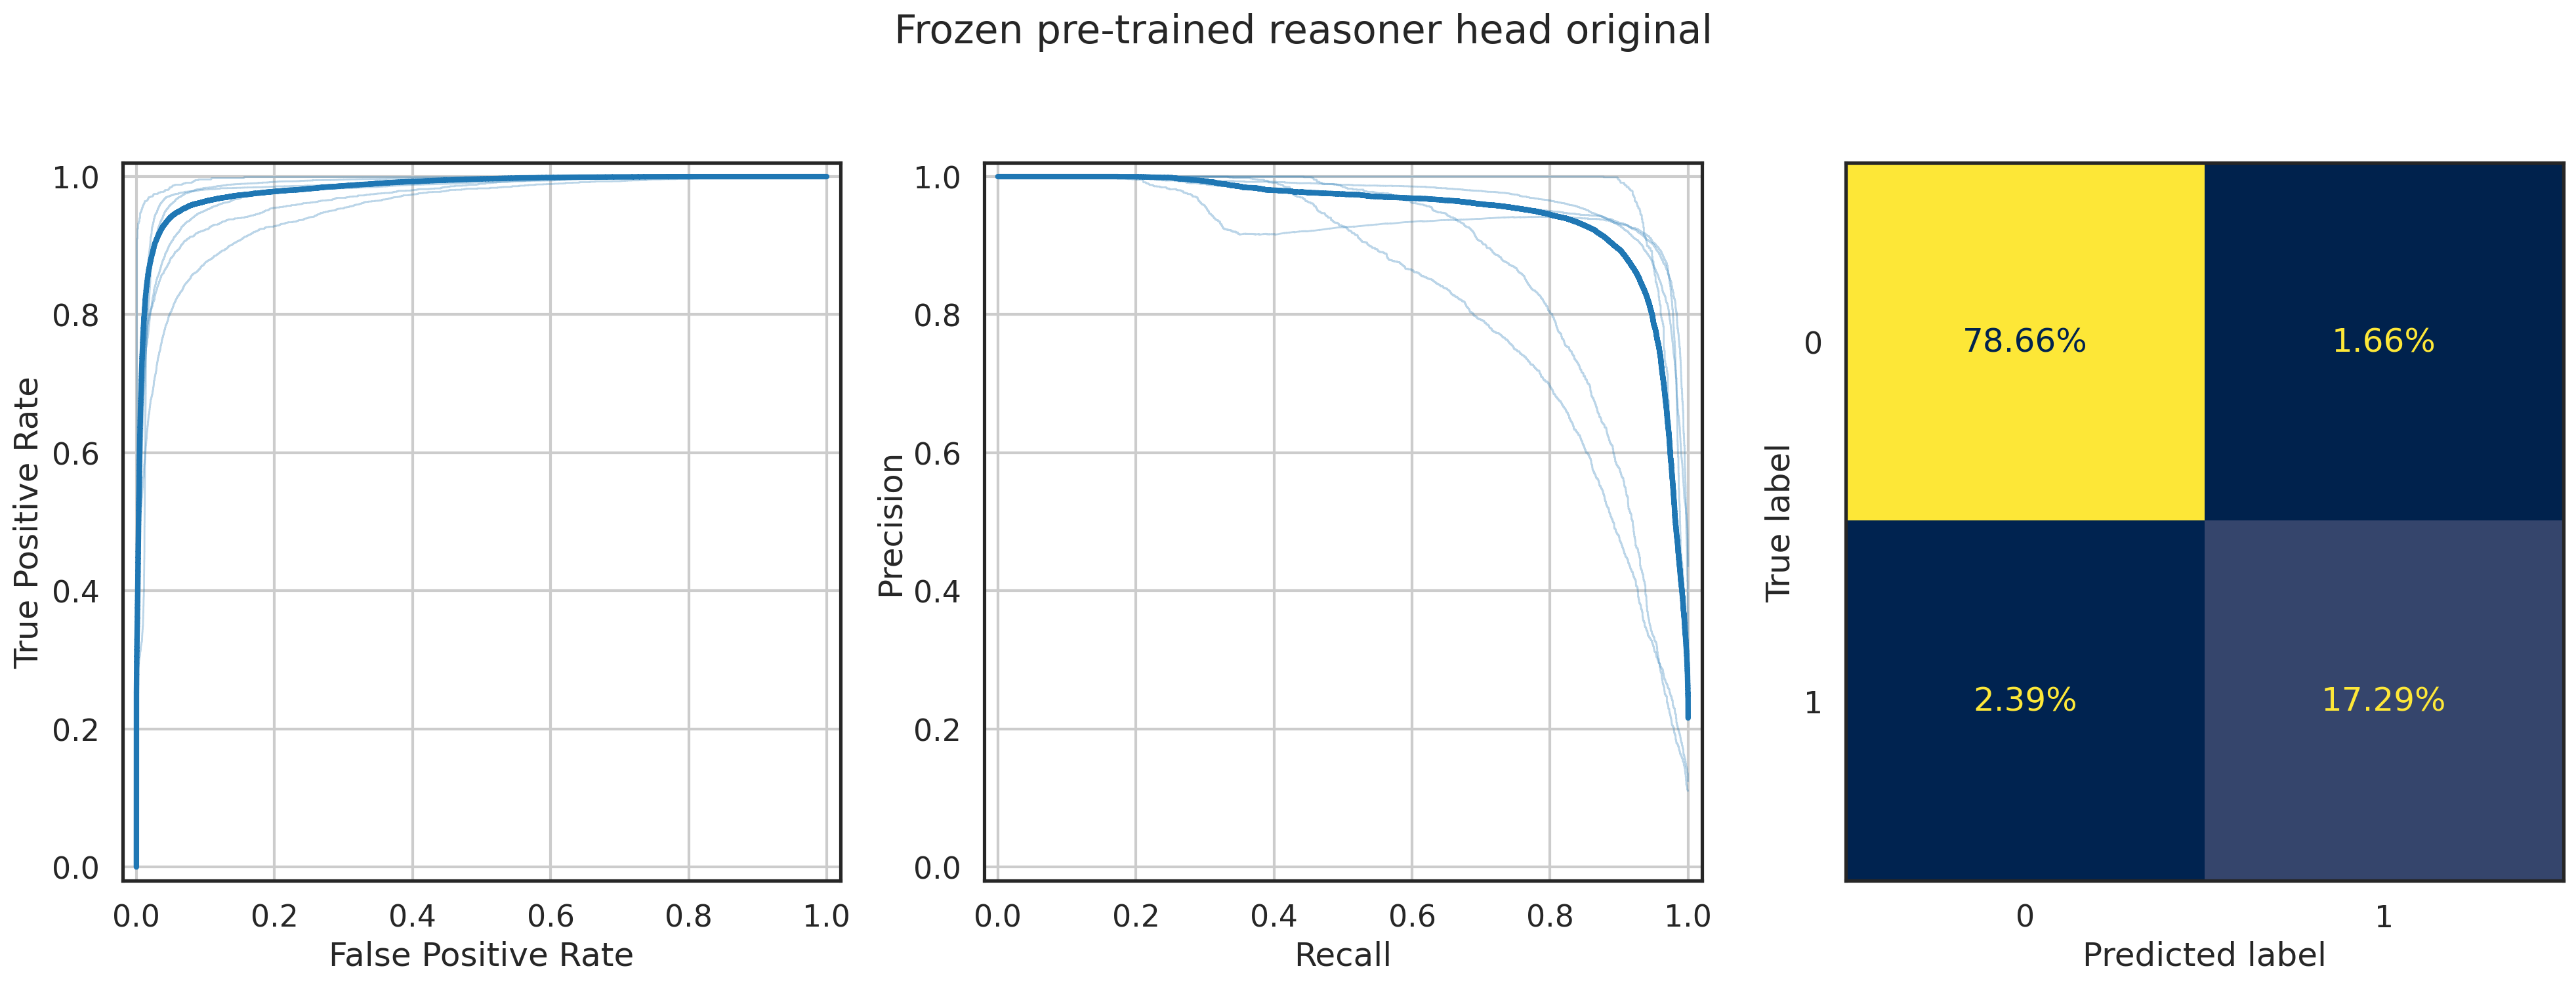

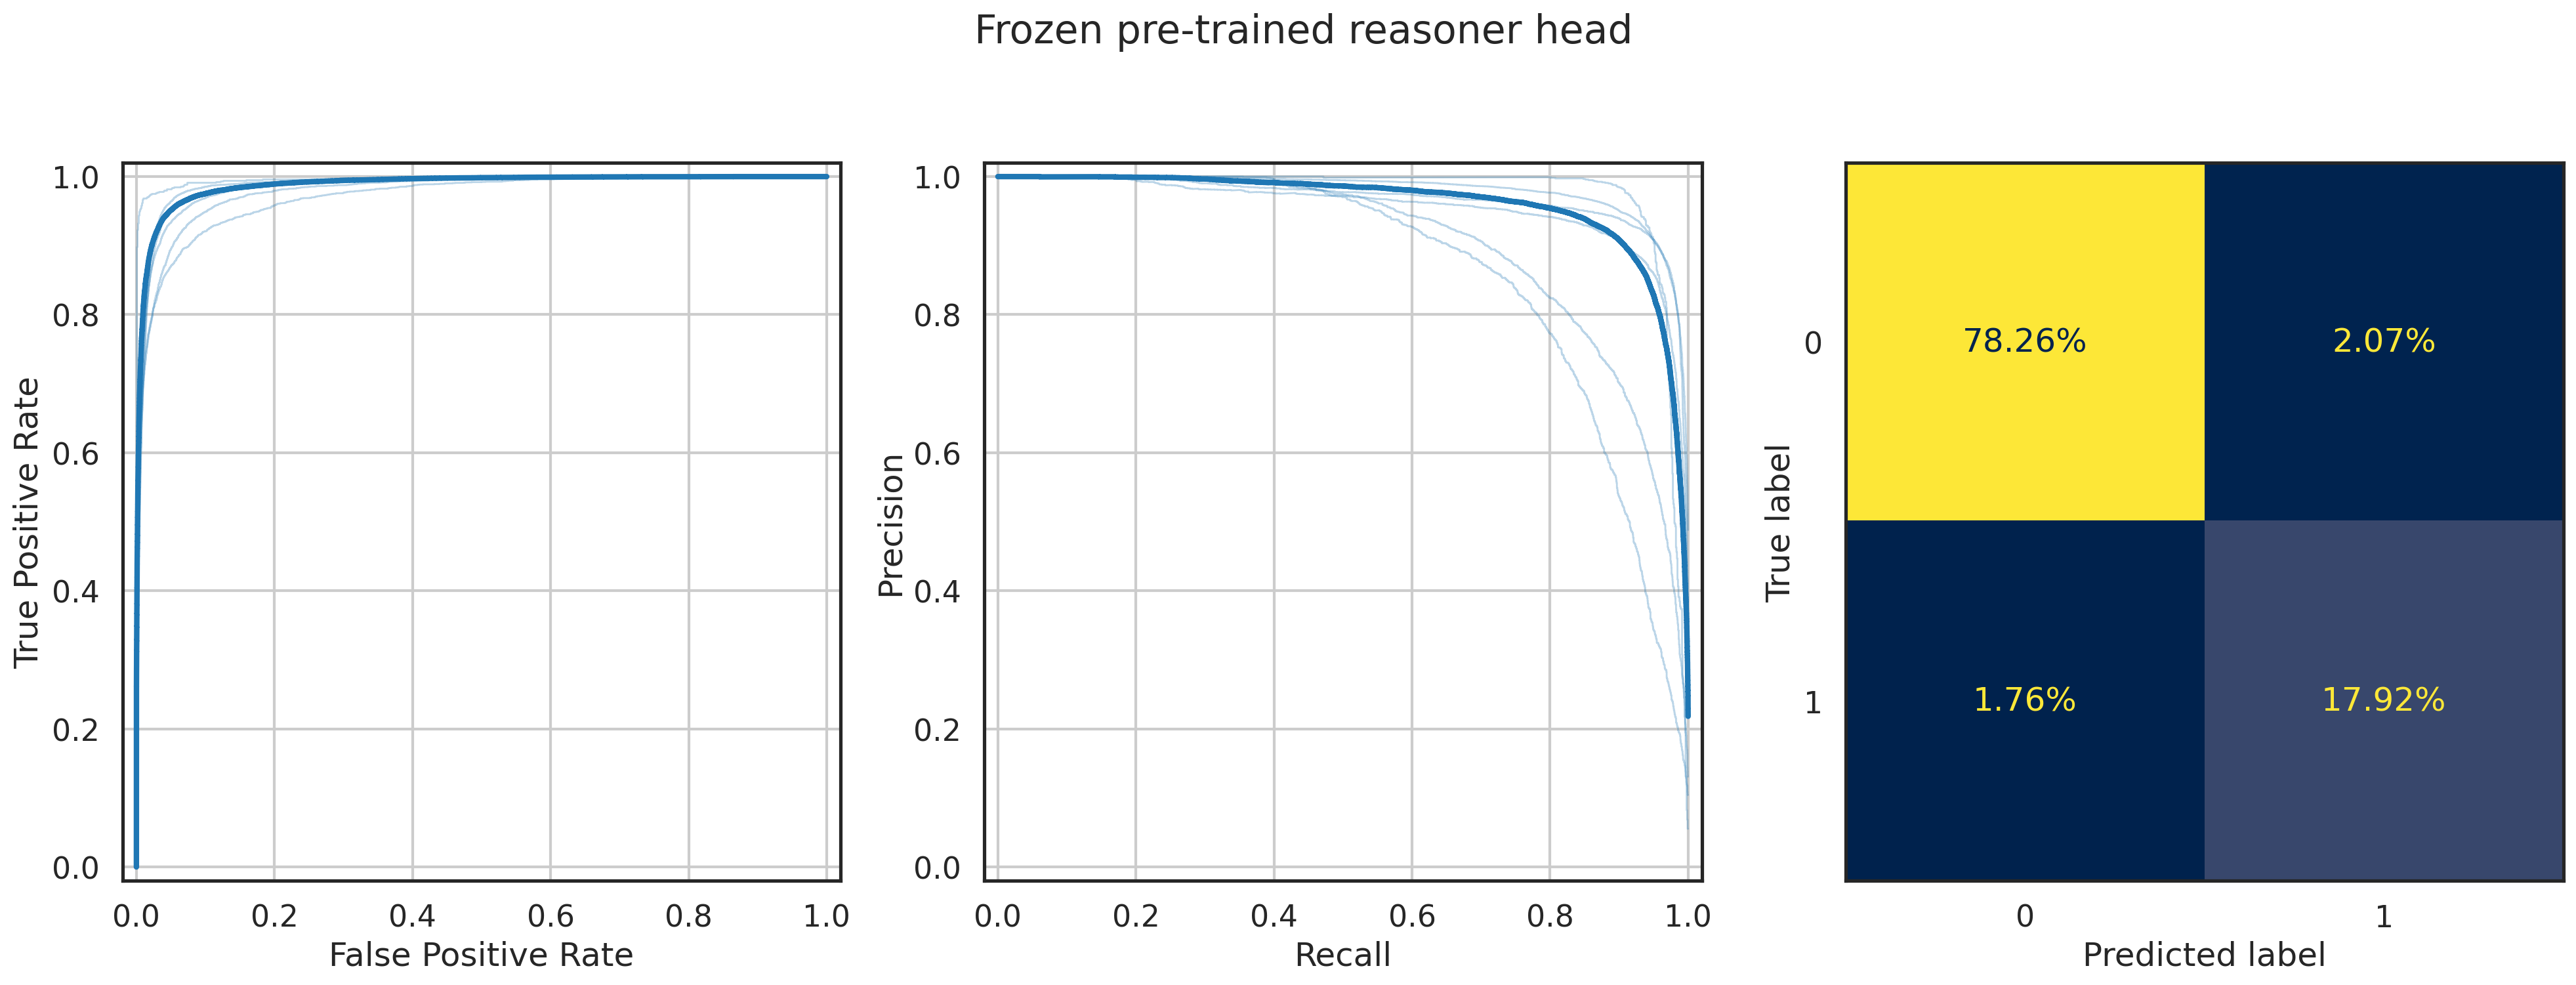

In [9]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [34]:
base = 'local/out/exp/' + 'exp5_frozen4'
mkdirp(base)
T.save(transfer_r_embs, base+'/emb_mod_layer.pt')
T.save(transfer_r_orig_embs, base+'/emb_orig_layer.pt')

In [35]:
a = T.load(base+'/emb_orig_layer.pt')

In [42]:
b = T.load(base+'/emb_mod_layer.pt')

In [8]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Frozen pre-trained reasoner head original
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9421  0.7396  0.8115  0.6793   0.9522  0.8353  wildlife
61  0.9956  0.9453  0.9984  0.8976   0.9979  0.9775  demacare
62  0.9651  0.9242  0.9251  0.9232   0.9827  0.9394     stuff
63  0.9558  0.9234  0.9186  0.9282   0.9864  0.9648       swo
64  0.9669  0.7942  0.8940  0.7145   0.9700  0.8818    ontodt
65  0.9315  0.9161  0.9210  0.9112   0.9763  0.9693     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9557  0.8107  0.8386  0.7847   0.9783  0.9029  wildlife
61  0.9948  0.9381  0.9440  0.9322   0.9963  0.9765  demacare
62  0.9556  0.9061  0.8833  0.9301   0.9863  0.9548     stuff
63  0.9576  0.9282  0.9035  0.9543   0.9879  0.9684       swo
64  0.9647  0.7914  0.8375  0.7502   0.9707  0.8688    ontodt
65  0.9424  0.9305  0.9218  0.9395   0.9854  0.9799     pizza


In [10]:
T.set_printoptions(precision=4)

In [103]:
import random

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod( input, input)))
F.mse_loss(input, transfer_r_head.and_nn(im_mod(input, input)))

tensor([ 0.0545, -0.0989,  0.1965,  0.2370,  0.0368,  0.0607, -0.2087, -0.0174,
         0.2981,  0.0674], grad_fn=<SelectBackward0>)
tensor([ 0.0355, -0.0497,  0.1022,  0.0538,  0.0473,  0.0259, -0.1352,  0.0030,
         0.1742,  0.0412], grad_fn=<AddBackward0>)


tensor(0.0068, grad_fn=<MseLossBackward0>)

In [31]:
import random

encoder = transfer_r_orig_embs[int(np.round(random.random() * (len(transfer_r_orig_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_orig_head.and_nn(im_mod( input, input)))
F.mse_loss(input, transfer_r_orig_head.and_nn(im_mod(input, input)))

tensor([-0.0345, -0.0374,  0.0895,  0.0254, -0.0682,  0.0083,  0.0898,  0.0618,
        -0.0449, -0.0655], grad_fn=<SelectBackward0>)
tensor([-0.0719, -0.0948,  0.0329,  0.1433,  0.0461,  0.2052,  0.1508, -0.0915,
         0.0866, -0.0025], grad_fn=<AddBackward0>)


tensor(0.0122, grad_fn=<MseLossBackward0>)

In [23]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
print(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)))
print(F.mse_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)), transfer_r_head.bot_concept[0]))

tensor([ 0.1507,  0.1034,  0.1662, -0.1940,  0.2302, -0.0654, -0.0161,  0.0138,
        -0.0972, -0.0808], grad_fn=<SelectBackward0>)
tensor([ 0.1498,  0.0808,  0.1321, -0.1780,  0.2120, -0.0854, -0.0535,  0.0579,
        -0.0661, -0.0988], grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)


In [24]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)))
print(F.mse_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)), input))

tensor([ 0.1045, -0.1963, -0.0229,  0.0368,  0.0252,  0.0795,  0.0838, -0.1139,
        -0.1187, -0.1102], grad_fn=<SelectBackward0>)
tensor([ 0.0531, -0.1285,  0.0010,  0.0690,  0.0202,  0.0828,  0.0842, -0.0798,
        -0.1238, -0.0342], grad_fn=<AddBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)


In [25]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
output = transfer_r_head.and_nn(im_mod(transfer_r_head.not_nn(input), input))
print(output)
print(F.mse_loss(output, input))


tensor([ 0.1507,  0.1034,  0.1662, -0.1940,  0.2302, -0.0654, -0.0161,  0.0138,
        -0.0972, -0.0808], grad_fn=<SelectBackward0>)
tensor([ 0.0296,  0.0107,  0.1262, -0.1325,  0.0960, -0.0334, -0.1418,  0.0180,
        -0.0451, -0.0133], grad_fn=<AddBackward0>)
tensor(0.0039, grad_fn=<MseLossBackward0>)


In [26]:
print(transfer_r_head.bot_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.top_concept[0])
print(output)
print(F.mse_loss(transfer_r_head.bot_concept[0], output))

tensor([ 0.1507,  0.1034,  0.1662, -0.1940,  0.2302, -0.0654, -0.0161,  0.0138,
        -0.0972, -0.0808], grad_fn=<SelectBackward0>)
tensor([ 0.1381,  0.1356,  0.1892, -0.2717,  0.2807, -0.0905, -0.0355,  0.0109,
        -0.0943, -0.1228], grad_fn=<SqueezeBackward3>)
tensor(0.0013, grad_fn=<MseLossBackward0>)


In [27]:
print(transfer_r_head.top_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.bot_concept[0])
print(output)
print(F.mse_loss(transfer_r_head.top_concept[0], output))

tensor([-0.0954, -0.2660, -0.0533,  0.4148,  0.0656,  0.1555,  0.4667,  0.2066,
        -0.2088,  0.2886], grad_fn=<SelectBackward0>)
tensor([-0.0266, -0.2249, -0.0211,  0.3548,  0.0496,  0.1343,  0.3979,  0.1862,
        -0.1755,  0.2490], grad_fn=<SqueezeBackward3>)
tensor(0.0020, grad_fn=<MseLossBackward0>)


In [28]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input1 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input2 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input3 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))))
print(transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))


F.mse_loss(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))), transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))

tensor([ 0.0896,  0.0893,  0.1495, -0.1570,  0.1763, -0.0506, -0.0373, -0.0389,
        -0.0818, -0.0858], grad_fn=<AddBackward0>)
tensor([ 0.1033,  0.0707,  0.1435, -0.1582,  0.1680, -0.0505, -0.0436, -0.0186,
        -0.0715, -0.0744], grad_fn=<AddBackward0>)


tensor(0.0001, grad_fn=<MseLossBackward0>)

In [29]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, input3)))
print(transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

tensor([ 0.0850,  0.0844,  0.1542, -0.1388,  0.1610, -0.0516, -0.0426, -0.0422,
        -0.0735, -0.0799], grad_fn=<AddBackward0>)
tensor([ 0.0774,  0.0776,  0.1453, -0.1347,  0.1567, -0.0506, -0.0467, -0.0254,
        -0.0781, -0.0657], grad_fn=<AddBackward0>)


tensor(7.4109e-05, grad_fn=<MseLossBackward0>)

In [30]:
print(input1)
print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

F.mse_loss(input1, transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

tensor([-0.1377,  0.1033,  0.2035, -0.0095,  0.0677, -0.0641, -0.1233, -0.1963,
        -0.0341, -0.1171], grad_fn=<SelectBackward0>)
tensor([-0.1016,  0.0434,  0.1809, -0.0038,  0.0586, -0.0193, -0.0947, -0.1767,
        -0.0166, -0.0567], grad_fn=<AddBackward0>)


tensor(0.0013, grad_fn=<MseLossBackward0>)